<a href="https://colab.research.google.com/github/mritula2311/EV-VEHICLE-DEMAND-AND-CHARGE-DEMAND-PREDICTION/blob/main/EV_Vehicle_Charging_Demand_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import pandas as pd
# --- Step 2: Load the Dataset ---
# Update the file_path to the name of your uploaded file.
file_path = '3ae033f50fa345051652.csv'
df = pd.read_csv(file_path)

print("--- Original Data Info ---")
df.info()
print(df.head())

# --- Step 3: Preprocessing the Data ---

# 1. Convert 'Date' column to a proper datetime format.
df['Date'] = pd.to_datetime(df['Date'])

# 2. Define the columns that should be numeric but are stored as text with commas.
numeric_cols = [
    'Battery Electric Vehicles (BEVs)',
    'Plug-In Hybrid Electric Vehicles (PHEVs)',
    'Electric Vehicle (EV) Total',
    'Non-Electric Vehicle Total',
    'Total Vehicles'
]

# Clean and convert these columns to integers.
for col in numeric_cols:
    df[col] = df[col].astype(str).str.replace(',', '').astype(int)

# 3. Handle missing values by dropping rows where 'County' or 'State' is not specified.
df.dropna(subset=['County', 'State'], inplace=True)

# 4. Feature Engineering: Extract Year, Month, and Day from the 'Date' column.
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

# --- Step 4: Display the Preprocessed Data ---
print("\n--- Preprocessed Data Info ---")
df.info()
print("\n--- First 5 Rows of Preprocessed Data ---")
print(df.head())


# --- (Optional) Step 5: Save the cleaned data to a new CSV file ---
# This will save the preprocessed dataframe to a new file in your Colab environment.
# You can then download it from the "Files" panel on the left.
df.to_csv('preprocessed_ev_data.csv', index=False)

print("\n✅ Preprocessing complete! The cleaned data is saved to 'preprocessed_ev_data.csv'")

--- Original Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20819 entries, 0 to 20818
Data columns (total 10 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Date                                      20819 non-null  object 
 1   County                                    20733 non-null  object 
 2   State                                     20733 non-null  object 
 3   Vehicle Primary Use                       20819 non-null  object 
 4   Battery Electric Vehicles (BEVs)          20819 non-null  object 
 5   Plug-In Hybrid Electric Vehicles (PHEVs)  20819 non-null  object 
 6   Electric Vehicle (EV) Total               20819 non-null  object 
 7   Non-Electric Vehicle Total                20819 non-null  object 
 8   Total Vehicles                            20819 non-null  object 
 9   Percent Electric Vehicles                 20819 non-null  float64
dtypes: floa

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- Step 0: Ensure the DataFrame is loaded and sorted ---
# This assumes 'df' is your preprocessed DataFrame from the previous steps.
# If not, load the preprocessed file first:
# df = pd.read_csv('preprocessed_ev_data.csv', parse_dates=['Date'])

# It is CRITICAL to sort the data by date for a time-series split
df = df.sort_values('Date').reset_index(drop=True)

print("--- Data sorted by Date ---")
print(df.head())


# --- Step 1: Define Features (X) and Target (y) ---
# For this example, let's predict the 'Electric Vehicle (EV) Total'.
# The features are all other relevant columns.
X = df.drop(columns=['Electric Vehicle (EV) Total', 'Date']) # Drop target and original date
y = df['Electric Vehicle (EV) Total']


# --- Step 2: Chronological Train-Test Split ---
# We will use the first 80% of the data for training and the most recent 20% for testing.
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"\n--- Data Split Chronologically ---")
print(f"Training set size: {len(X_train)} rows")
print(f"Testing set size: {len(X_test)} rows")
print(f"Training data goes up to date: {df['Date'].iloc[split_index-1]}")
print(f"Testing data starts from date: {df['Date'].iloc[split_index]}")


# --- Step 3: Create Preprocessing Pipelines for Column Types ---
# We need to treat categorical and numerical columns differently.

# Identify categorical and numerical feature names
categorical_features = ['County', 'State', 'Vehicle Primary Use']
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns

# Create a preprocessing pipeline for numerical data (scaling)
numerical_transformer = StandardScaler()

# Create a preprocessing pipeline for categorical data (one-hot encoding)
# handle_unknown='ignore' tells the encoder to ignore categories that appear in the
# test set but not in the training set.
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any) untouched
)


# --- Step 4: Apply the Preprocessing to the Data ---
# The preprocessor is 'fitted' on the training data to learn the scaling parameters
# and the categories, and then it 'transforms' both the training and test data.

X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)


# --- Step 5: Inspect the Final Prepared Data ---
print("\n--- Preprocessing Complete ---")
print("Shape of the final prepared training data (X_train_prepared):")
print(X_train_prepared.shape)

print("\nShape of the final prepared testing data (X_test_prepared):")
print(X_test_prepared.shape)
df.to_csv('preprocessed_ev_datacharge.csv', index=False)
# Note: The output is a sparse matrix because of one-hot encoding,
# which is efficient for storage.
print("\nExample of a few rows from the prepared training data:")
print(X_train_prepared[:5])
print("\n✅ Advanced preprocessing is complete. The data is now ready for model training.")

--- Data sorted by Date ---
        Date   County State Vehicle Primary Use  \
0 2017-01-31    Brown    WI           Passenger   
1 2017-01-31   Hawaii    HI           Passenger   
2 2017-01-31   Benton    WA               Truck   
3 2017-01-31  Madison    ID           Passenger   
4 2017-01-31   Chelan    WA           Passenger   

   Battery Electric Vehicles (BEVs)  Plug-In Hybrid Electric Vehicles (PHEVs)  \
0                                 1                                         0   
1                                 1                                         0   
2                                 0                                         0   
3                                 1                                         0   
4                                54                                        28   

   Electric Vehicle (EV) Total  Non-Electric Vehicle Total  Total Vehicles  \
0                            1                          46              47   
1                     

# Task
Explain the error in the selected code, fix it if possible, and then generate an ML model for demand prediction using the provided data.

## Choose a model

### Subtask:
Select a suitable model for this regression task. Since this is time-series data, models like ARIMA, or even tree-based models with time-based features could be considered. We can start with a simple yet effective model like a Gradient Boosting Regressor.


**Reasoning**:
Import the necessary model and instantiate it as requested.



In [10]:
from sklearn.ensemble import GradientBoostingRegressor

# Instantiate a Gradient Boosting Regressor model
gbr_model = GradientBoostingRegressor()

## Train the model

### Subtask:
Train the chosen model on the preprocessed training data (`X_train_prepared` and `y_train`).


**Reasoning**:
Train the Gradient Boosting Regressor model using the preprocessed training data.



In [11]:
# Train the Gradient Boosting Regressor model
gbr_model.fit(X_train_prepared, y_train)

print("Gradient Boosting Regressor model trained successfully.")

Gradient Boosting Regressor model trained successfully.


## Make predictions

### Subtask:
Use the trained model to make predictions on the preprocessed testing data (`X_test_prepared`).


**Reasoning**:
Use the trained Gradient Boosting Regressor model to make predictions on the preprocessed testing data and display the first few predictions.



In [12]:
# Use the trained model to make predictions on the preprocessed testing data
y_pred = gbr_model.predict(X_test_prepared)

# Print the first few predicted values
print("--- First 5 Predicted Values ---")
print(y_pred[:5])

--- First 5 Predicted Values ---
[1.29512740e+00 8.18512809e+03 1.24018208e+00 1.26572989e+04
 1.24018208e+00]


## Evaluate the model

### Subtask:
Evaluate the model's performance using appropriate regression metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), and R-squared.


**Reasoning**:
Calculate and print the evaluation metrics (MAE, MSE, R-squared) for the model's predictions.



In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate the R-squared score
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

Mean Absolute Error (MAE): 69.77320001024759
Mean Squared Error (MSE): 1318303.5252078937
Root Mean Squared Error (RMSE): 1148.173996051075
R-squared (R2): 0.9412199305249961


## Visualize results

### Subtask:
Visualize the predicted values against the actual values to get a better understanding of the model's performance.


**Reasoning**:
Visualize the actual vs. predicted values using a scatter plot and a diagonal line for reference.



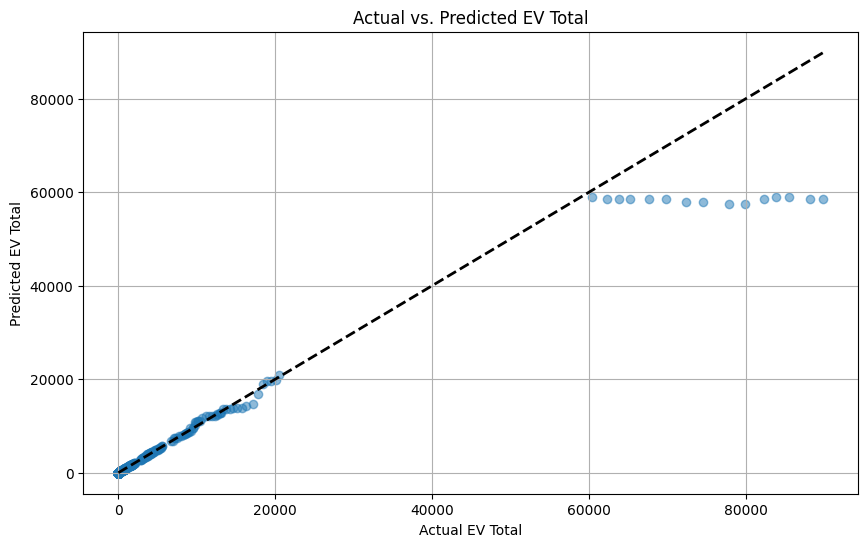

In [14]:
import matplotlib.pyplot as plt

# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)

# Add a diagonal line for perfect predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

# Add titles and labels
plt.title("Actual vs. Predicted EV Total")
plt.xlabel("Actual EV Total")
plt.ylabel("Predicted EV Total")

# Add a grid
plt.grid(True)

# Display the plot
plt.show()

## Summary:

### Data Analysis Key Findings

*   The Gradient Boosting Regressor model achieved a Mean Absolute Error (MAE) of approximately 69.77 on the test data.
*   The Mean Squared Error (MSE) for the model on the test data was approximately 1,318,303.53.
*   The R-squared (R2) score for the model on the test data was approximately 0.9412, indicating a good fit to the data.

